In [ ]:
################################################################## GENERAL IDEA ###################################################################
###################################################################################################################################################
############################################################### 1. PRE PROCESSING #################################################################
###################################################################################################################################################
## Create a data frame from csv file, then create two data frames one for each Station types (start, end) for easier data handling. 
## Making sure data are sorted by datetimes, handling missing data (if any), getting rid of data we do not care about, converting certain columns 
## to certain data types if needed.
## Then, create intervals and calculate values for each interval, handle upper/lower interval problems, and finally creating the final time_serie, 
## handling missing values if necessary. 
## All of the above are being conducted inside a function wich returns the final time series. 
## I did this because I wanted to easily create different time series using different intervals for testing purposes.
## At the end of pre processing, we devide the time series into training and testing data. This is also being conducted in a function because
## I wanted to easily create different training/testing data analogies for testing purposes.
###################################################################################################################################################


**PREPROCESSING OF DATA**

In [5]:
######################### Time series creating function, using a file name and an integer representing the interval in hours ###########################

# Importing pandas library
import pandas as pd

def csvDataToTimeSerie(fileName, timeInterInHours):  
    # Creating a pandas data frame with the raw data of the csv file
    raw_df = pd.read_csv(fileName)

    # Creating separate data frames for start and end stations
    
    raw_start_df = raw_df[['TripId', 'StartTime', 'StartStationId']]
    raw_end_df = raw_df[['TripId', 'EndTime', 'EndStationId']]
    
    # Making sure the data we are going to work on are sorted by timestamp
    
    raw_start_sorted_df = raw_start_df.sort_values(by='StartTime')
    raw_end_sorted_df = raw_end_df.sort_values(by='EndTime')
    
    # Keeping only data that we want in each data frame (deleting entries where station id is not equal to 1)
    # Also resetting the data frames' indexes for better visualization-manipulation of data
    
    condition = raw_start_sorted_df['StartStationId'] == 1
    raw_start_sorted_df = raw_start_sorted_df[condition]
    raw_start_sorted_df = raw_start_sorted_df.reset_index(drop='True')
    
    condition = raw_end_sorted_df['EndStationId'] == 1
    raw_end_sorted_df = raw_end_sorted_df[condition]
    raw_end_sorted_df = raw_end_sorted_df.reset_index(drop='True')
    
    # Checking if there are NaN values in the the raw data frames
    
    start_df_nan_check = raw_start_sorted_df.isna().any()
    end_df_nan_check = raw_end_sorted_df.isna().any()
    # In this project there are non. If there where, we would have to decide how to deal with the empty spots
    
    # Converting Time columns to timestamps so that certain functions can be used on them
    
    raw_start_sorted_df['StartTime'] = pd.to_datetime(raw_start_sorted_df['StartTime'])
    raw_end_sorted_df['EndTime'] = pd.to_datetime(raw_end_sorted_df['EndTime'])

    # Defining the start and end timestamps of the time series
    # First we compare the min and max timestamps from the two data frames
    # and we keep the overall min and max timestamps
    
    start_time_1 = raw_start_sorted_df['StartTime'].min()
    start_time_2 = raw_end_sorted_df['EndTime'].min()
    if (start_time_1 > start_time_2):
        start_time = start_time_2
    else:
        start_time = start_time_1
    
    end_time_1 = raw_start_sorted_df['StartTime'].max()
    end_time_2 = raw_end_sorted_df['EndTime'].max()
    if (end_time_1 > end_time_2):
        end_time = end_time_1
    else:
        end_time = end_time_2
    
    # Then we round the starting and ending hour (to the floor and ceiling hours respectively)
    
    start_time = start_time.floor('h')
    end_time = end_time.ceil('h')
    
    # This if will take action only if the timeInterInHours exactly devides 24 (total hours per day)
    # Not necessary but if the above is the case, then intervals deviding the total period will not split between different days
    
    if 24 % timeInterInHours == 0:
        start_mod = start_time.hour % timeInterInHours
        if start_mod != 0:
            start_time -= pd.Timedelta(hours=start_mod)
        
        end_mod = end_time.hour % timeInterInHours
        if end_mod != 0:
            end_time += pd.Timedelta(hours=end_mod)
    
    # Creating the final timestamp values of the time series using a frequency of timeInterInHours hours
    # and inserting it into a pandas data frame
    # Each timestamp of the time_serie will indicate the demand for the time period [current_timestamp, current_timestamp+Xhours)
    
    interval = str(timeInterInHours) + 'h'
    timestamps = pd.date_range(start=start_time, end=end_time, freq=interval)
    
    # There is a change that the max timestamp created is less than the end_time of our data.
    # If this is the case we add one more interval, so that we will not miss any data when creating the time serie
    
    if (timestamps[-1] < end_time):
        extra_timestamp = timestamps[-1] + pd.Timedelta(hours=timeInterInHours)
        timestamps = timestamps.append(pd.DatetimeIndex([extra_timestamp]))
    
    # Creating the total period for the time serie
    
    pre_time_serie = pd.DataFrame({'Time': timestamps})
    
    # Calculating the bicycles taken and returned in each period,
    # and then calculating the demand in ech period by subtracting the above
    
    pre_time_serie['Taken'] = 0
    pre_time_serie['Returned'] = 0
    
    # Inserting the taken bicycle values
    i = 0
    max_i = raw_start_sorted_df.index.max()
    max_index = pre_time_serie.index.max()
    for index in range(0, max_index):
        count = 0
        cur_time = raw_start_sorted_df.loc[i, 'StartTime']
        low_time = pre_time_serie.loc[index, 'Time']
        high_time = pre_time_serie.loc[index+1, 'Time']
        while (cur_time>=low_time and cur_time<high_time):
            count += 1
            i += 1
            if (i>max_i): break
            cur_time = raw_start_sorted_df.loc[i, 'StartTime']
        pre_time_serie.loc[index, 'Taken'] = count
        if (i>max_i): break
    
    # Inserting the returned bicycle values
    i = 0
    max_i = raw_end_sorted_df.index.max()
    for index in range(0, max_index):
        count = 0
        cur_time = raw_end_sorted_df.loc[i, 'EndTime']
        low_time = pre_time_serie.loc[index, 'Time']
        high_time = pre_time_serie.loc[index+1, 'Time']
        while (cur_time>=low_time and cur_time<high_time):
            count += 1
            i += 1
            if (i>max_i): break
            cur_time = raw_end_sorted_df.loc[i, 'EndTime']
        pre_time_serie.loc[index, 'Returned'] = count
        if (i>max_i): break
    
    # Creating the resulting time serie by deleted columns that are not needed,
    # deleting the last row, which does not represent a period we want
    # and make the timestamps' column the index
    # We do not have to handle missing values etc,
    # because as we can see from the raw data set, data is spread in any kind day/hour
    
    # If we had to deal with missing values, then usually one of three methods is chosen:
    # 1. Fill with front interval's value with time_serie.Demand.fillna(method = 'bfill') a.k.a "back filling"
    # 2. Fill with back interval's value with time_serie.Demand.fillna(method = 'ffill') a.k.a "front filling"
    # 3. Fill with the mean of all time_serie data with time_serie.Demand.fillna(value = time_serie.Demand.mean()) -- NOT good choice for time series
    #    because usually we observe a periodicity in data and data are strongly connected with neighbor data
    
    pre_time_serie['Demand'] = pre_time_serie['Returned'] - pre_time_serie['Taken']
    time_serie = pre_time_serie.copy()
    time_serie.drop(columns=['Returned'], inplace=True)
    time_serie.drop(columns=['Taken'], inplace=True)
    time_serie.drop(time_serie.index[-1], inplace=True)
    time_serie.set_index('Time', inplace=True)
    return time_serie

############################################ Function to split the time series into training and testing data #######################################

def timeSerieSplit(time_serie, training_perc, testing_perc):
    size = int(len(time_serie)*training_perc)
    training_data = time_serie.iloc[:size]
    testing_data = time_serie.iloc[size:]
    return training_data, testing_data

In [7]:
########### Creating a time series from the data.csv file's data, with a 2 hour interval and splitting into 70% training, 30% testing data ############

time_serie = csvDataToTimeSerie('data.csv', 2)
print(time_serie)
ts, ts_test = timeSerieSplit(time_serie, 0.7, 0.3)
print(ts)
print(ts_test)

                     Demand
Time                       
2023-02-01 00:00:00      -1
2023-02-01 02:00:00       0
2023-02-01 04:00:00       1
2023-02-01 06:00:00     -10
2023-02-01 08:00:00      -7
...                     ...
2023-02-28 14:00:00       4
2023-02-28 16:00:00       8
2023-02-28 18:00:00       6
2023-02-28 20:00:00       4
2023-02-28 22:00:00      10

[336 rows x 1 columns]
                     Demand
Time                       
2023-02-01 00:00:00      -1
2023-02-01 02:00:00       0
2023-02-01 04:00:00       1
2023-02-01 06:00:00     -10
2023-02-01 08:00:00      -7
...                     ...
2023-02-20 04:00:00       0
2023-02-20 06:00:00      -8
2023-02-20 08:00:00      -1
2023-02-20 10:00:00      -1
2023-02-20 12:00:00       1

[235 rows x 1 columns]
                     Demand
Time                       
2023-02-20 14:00:00      13
2023-02-20 16:00:00      -3
2023-02-20 18:00:00       9
2023-02-20 20:00:00       4
2023-02-20 22:00:00       5
...                     ...


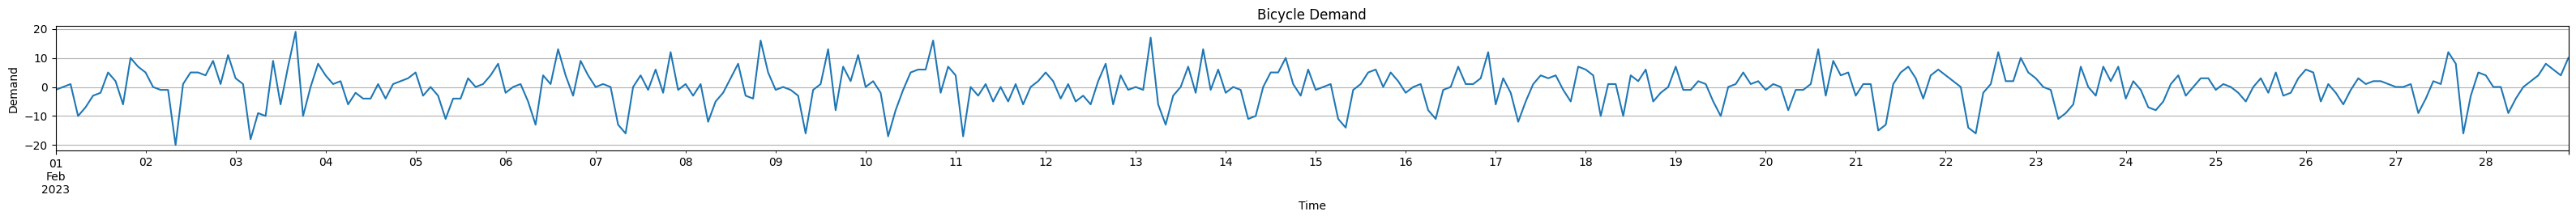

In [17]:
# Plotting the time serie through the data frame

import matplotlib.pyplot as plt

time_serie.Demand.plot(figsize = (40, 2))
plt.title("Bicycle Demand")
plt.xlabel("Time")
plt.ylabel("Demand")
plt.grid()
plt.show()

In [ ]:
import scipy.stats as sc
import pylab
plt.rcParams["figure.figsize"] = (15, 8)
sc.probplot(time_serie.Demand, plot = pylab)
pylab.show()